# STDFT in Analize signalov

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def compute_stdft(signal, sample_rate, window_ms, overlap_ratio):
    window_len = int((window_ms / 1000) * sample_rate)
    hop_size = int(window_len * (1 - overlap_ratio))
    # print(f"Window length: {window_len} samples, Hop size: {hop_size} samples")

    window = np.hamming(window_len)

    # Računanje števila frame-ov in dopolnitev z ničlami (padding)
    num_frames = int(np.ceil((len(signal) - window_len) / hop_size)) + 1
    total_len = hop_size * (num_frames - 1) + window_len
    padded_signal = np.pad(signal, (0, total_len - len(signal)), mode='constant')

    stft_result = []

    for i in range(num_frames):
        start = i * hop_size
        end = start + window_len
        frame = padded_signal[start:end] * window
        spectrum = np.fft.fft(frame, n=window_len)
        stft_result.append(np.abs(spectrum[:window_len // 2]))

    stft_matrix = np.array(stft_result).T  # shape: [freq, times]

    freqs = np.fft.fftfreq(window_len, d=1/sample_rate)[:window_len // 2]
    times = np.arange(num_frames) * hop_size / sample_rate

    return freqs, times, stft_matrix

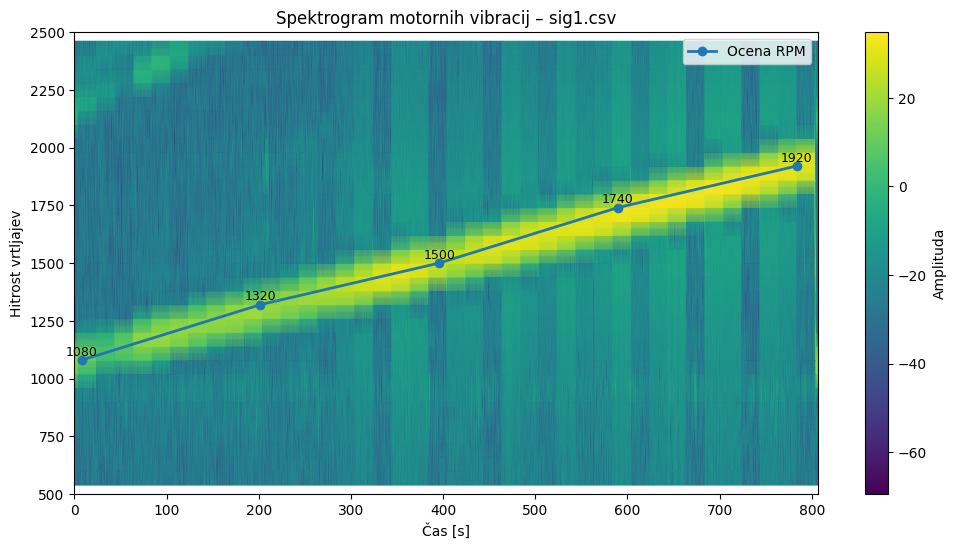

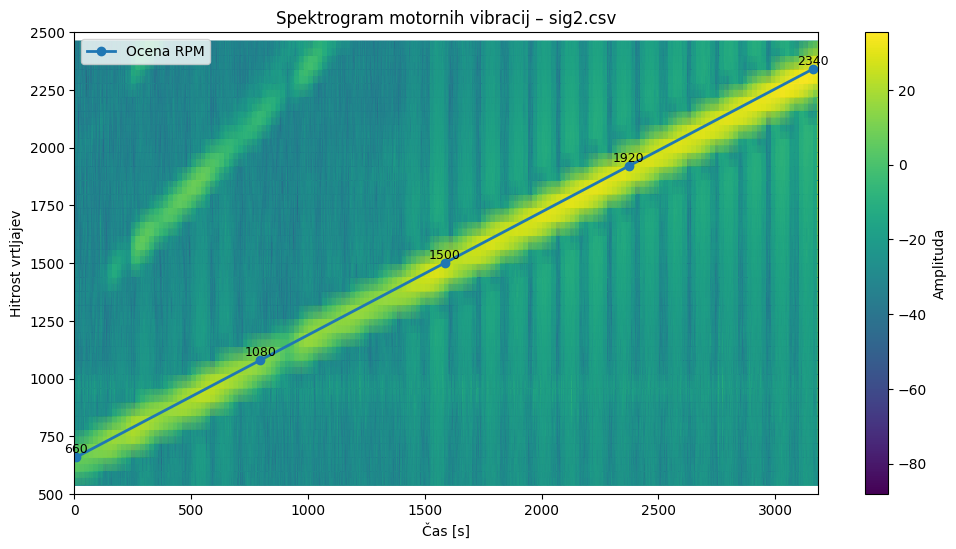

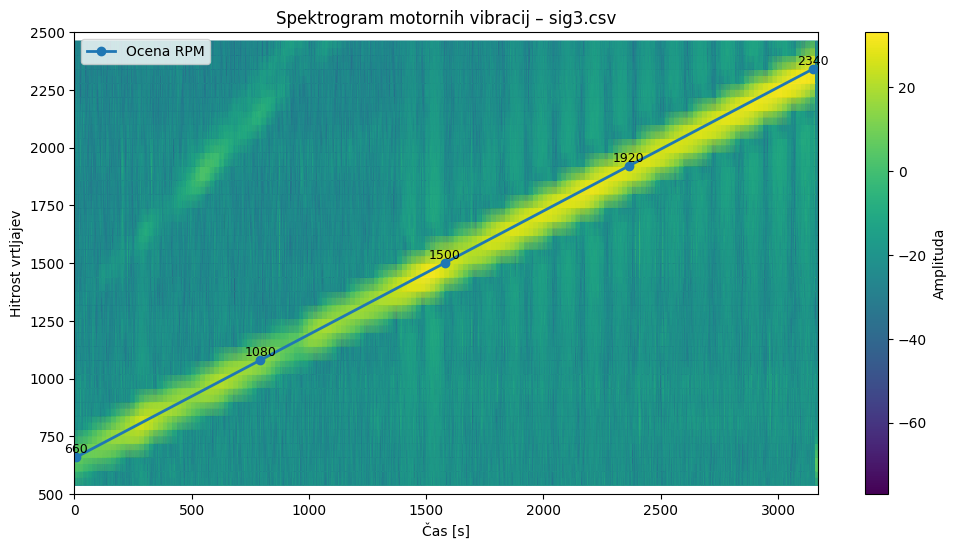

In [12]:
import os

def procesiraj_posketke():
    folder = 'rpm_vib'
    files = [f for f in os.listdir(folder) if f.lower().endswith('.csv')]
    for file in files[:]:
        filepath = os.path.join(folder, file)

        data = np.loadtxt(filepath, delimiter=',')
        y = (data / np.max(np.abs(data))).astype(np.float32)

        freqs, times, stft = compute_stdft(y, sample_rate=256, window_ms=1000, overlap_ratio=0.75)

        fmin, fmax = 500/60, 2500/60
        mask = (freqs >= fmin) & (freqs <= fmax)
        freqs_filtered = freqs[mask]
        stft_filtered = stft[mask, :]

        # Dominantna frekvenca v vsakem časovnem segmentu
        dominant_indices = np.argmax(stft_filtered, axis=0)
        dominant_freqs = freqs_filtered[dominant_indices]
        dominant_rpm = dominant_freqs * 60

        plt.figure(figsize=(12, 6))
        # freqs_filtered*60 da pretvorimo v RPM
        plt.pcolormesh(times, freqs_filtered*60,
                       20*np.log10(stft_filtered+1e-6), shading='gouraud')
        plt.colorbar(label="Amplituda")
        plt.ylabel("Hitrost vrtljajev")
        plt.xlabel("Čas [s]")
        plt.title(f"Spektrogram motornih vibracij – {file}")

        # plt.plot(times, dominant_rpm, color="red", linewidth=2, label="Ocena RPM")
        points = np.linspace(32, len(times)-96, 5, dtype=int)
        plt.plot(times[points], dominant_rpm[points], 'o-', linewidth=2, label="Ocena RPM")
        for idx in points: # oznake
            plt.text(times[idx], dominant_rpm[idx]+20, f"{int(dominant_rpm[idx])}", fontsize=9, ha='center')

        plt.ylim(500, 2500)
        plt.legend()
        plt.show()


procesiraj_posketke()